Notebook to analyze individual results for the paper

In [81]:
import pandas as pd
import pymc as pm
import arviz as az
import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
sns.set_style("whitegrid")

from src.diffusivity import (
    calc_tilda_c, 
    linear_diffusivity, 
    within_ellipsoid, 
    calculate_lsq_diffusivities
    )

In [117]:
well = 3
stage = 72

# load stage distances
stg_dist = pd.read_csv('data/ms_stage_distances.csv').query("WellID == @well").query("Stage == @stage")

In [118]:
# apply ellipsoid filter again
# run the plausible ellipsoid filter
stg_dist["in_frac_ellipsoid"] = within_ellipsoid(
    stg_dist[["dx_strike_m", "dy_strike_m", "dz_strike_m"]].to_numpy(),
    ellipsoid_rxryrz=(1000, 400, 600)
)

In [119]:
# load results, model, and trace for linear and nonlinear models
linear_results = pd.read_parquet(f"outputs/{well}_{stage}_linear.parquet")

with open(f"outputs/{well}_{stage}_lineartrace.pkl", 'rb') as f:
    linear_trace = cloudpickle.load(f)

with open(f"outputs/{well}_{stage}_linearmodel.pkl", 'rb') as f:
    linear_model = cloudpickle.load(f)

nonlinear_results = pd.read_parquet(f"outputs/{well}_{stage}_nonlinear.parquet")

with open(f"outputs/{well}_{stage}_nonlineartrace.pkl", 'rb') as f:
    nonlinear_trace = cloudpickle.load(f)

with open(f"outputs/{well}_{stage}_nonlinearmodel.pkl", 'rb') as f:
    nonlinear_model = cloudpickle.load(f)


(0.0, 1000.0)

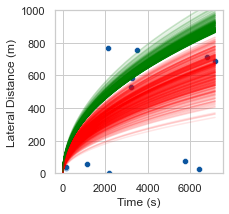

In [120]:
# posterior predictive check
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(3,3))
t = np.linspace(1,stg_dist.t_start_s.max(),1000)
sns.scatterplot(x=stg_dist.t_start_s,y=stg_dist.dx_strike_m.abs(), ax=ax)
for chain in nonlinear_trace.posterior.chain.values:
    draws = np.random.choice(linear_trace.posterior.sel({'chain':chain}).draw.values, 100)
    for draw in draws:
        k = nonlinear_trace.posterior.sel({'chain':chain, 'draw':draw}).k.values
        Po = nonlinear_trace.posterior.sel({'chain':chain, 'draw':draw}).Po.values
        Do = nonlinear_trace.posterior.sel({'chain':chain, 'draw':draw}).Do_x.values
        sns.lineplot(x=t, y=np.sqrt(6*Do*t), color='red', alpha=0.1)
        sns.lineplot(x=t, y=calc_tilda_c(k, Po)*np.sqrt(Do*t), color='green', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Lateral Distance (m)')
plt.ylim(0,1000)

# Linear Trace Analysis

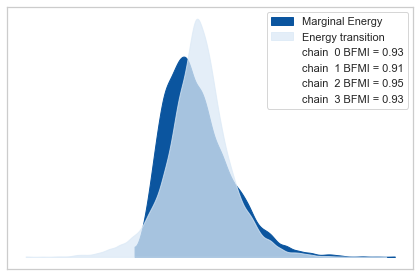

In [66]:
# energy plot
sns.set_style("whitegrid")
sns.set_palette("Blues_r")
az.plot_energy(linear_trace)
plt.tight_layout()
plt.show()

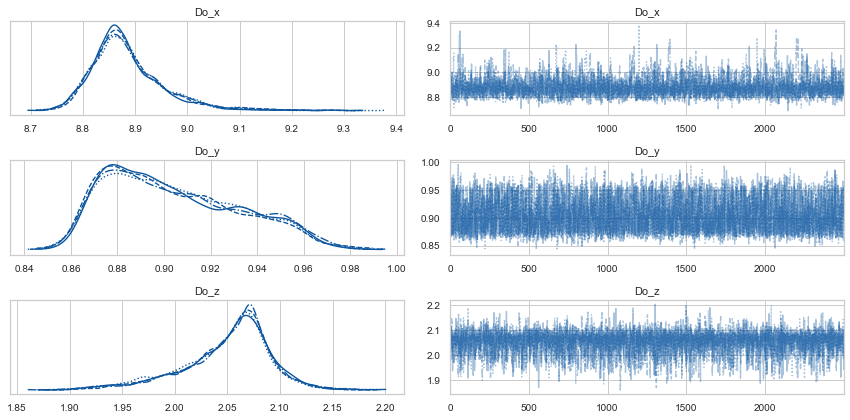

In [55]:
# trace plot - linear model
sns.set_style("whitegrid")
sns.set_palette('Blues_r')
az.plot_trace(linear_trace, trace_kwargs={'color':'red'})
plt.tight_layout()
plt.show()

c:\repos\bayesian_diffusivity_inference\src\diffusivity.py:162: RuntimeWarning: invalid value encountered in log
  positive_x = mu - sigma/p * np.log((1-u)/(1-p))


(0.0, 1000.0)

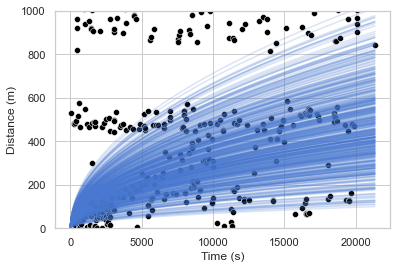

In [47]:
# prior predictive check
with linear_model:
    prior_pred_check = pm.sample_prior_predictive(samples=500)

t = np.linspace(1,stg_dist.t_start_s.max(),1000)
for draw in prior_pred_check.prior.draw.values:
    Do = prior_pred_check.prior.sel({'draw':draw}).Do_x.values[0]
    sns.lineplot(x=t, y=np.sqrt(6*Do*t), color='#4878d0', alpha=0.2)
sns.scatterplot(x=stg_dist.t_start_s,y=stg_dist.dx_strike_m.abs(), color='black')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.ylim(0,1000)

(0.0, 1000.0)

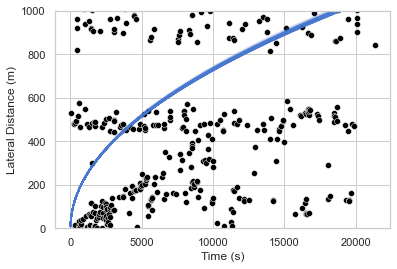

In [71]:
# posterior predictive check
for chain in linear_trace.posterior.chain.values:
    draws = np.random.choice(linear_trace.posterior.sel({'chain':chain}).draw.values, 100)
    for draw in draws:
        Do = linear_trace.posterior.sel({'chain':chain, 'draw':draw}).Do_x.values
        sns.lineplot(x=t, y=np.sqrt(6*Do*t), color='#4878d0', alpha=0.1)
sns.scatterplot(x=stg_dist.t_start_s,y=stg_dist.dx_strike_m.abs(), color='black')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Distance (m)')
plt.ylim(0,1000)

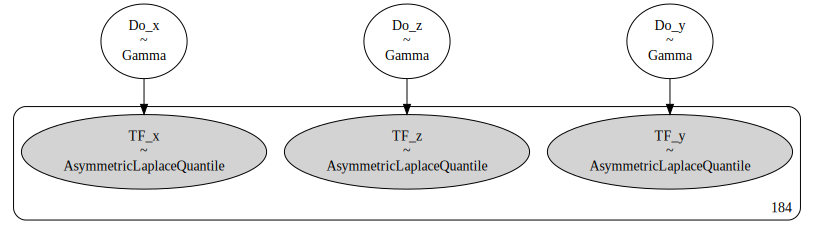

In [62]:
gv = pm.model_to_graphviz(linear_model)
gv.render(filename='model',format='pdf')
gv

# Nonlinear Model Analysis

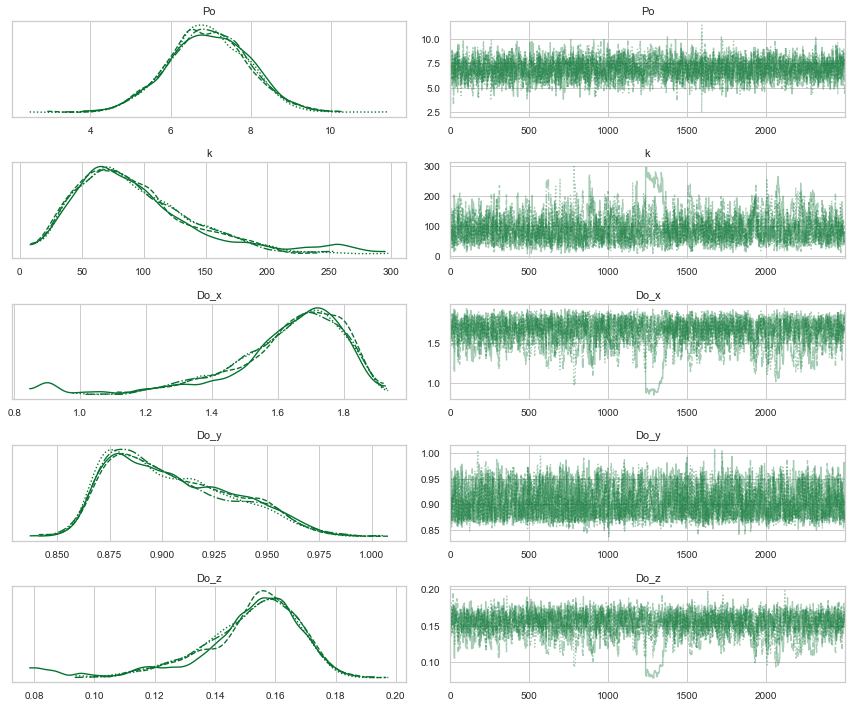

In [63]:
# trace plot 
sns.set_style("whitegrid")
sns.set_palette('Greens_r')
az.plot_trace(nonlinear_trace)
plt.tight_layout()
plt.show()

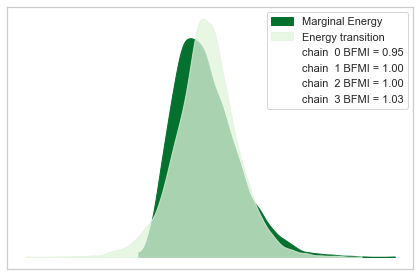

In [65]:
# energy plot
sns.set_style("whitegrid")
sns.set_palette('Greens_r')
az.plot_energy(nonlinear_trace)
plt.tight_layout()
plt.show()

c:\repos\bayesian_diffusivity_inference\src\diffusivity.py:162: RuntimeWarning: invalid value encountered in log
  positive_x = mu - sigma/p * np.log((1-u)/(1-p))


(0.0, 1000.0)

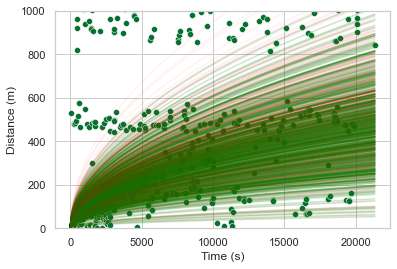

In [41]:
# prior predictive check
with nonlinear_model:
    prior_pred_check = pm.sample_prior_predictive(samples=500)

sns.scatterplot(x=stg_dist.t_start_s,y=stg_dist.dx_strike_m.abs())
t = np.linspace(1,stg_dist.t_start_s.max(),1000)
for draw in prior_pred_check.prior.draw.values:
    Do = prior_pred_check.prior.sel({'draw':draw}).Do_x.values[0]
    sns.lineplot(x=t, y=np.sqrt(6*Do*t), color='green', alpha=0.2)
    if 'k' in prior_pred_check.prior.keys():
        k = prior_pred_check.prior.sel({'draw':draw}).k.values[0]
        Po = prior_pred_check.prior.sel({'draw':draw}).Po.values[0]
        sns.lineplot(x=t, y=calc_tilda_c(k, Po)*np.sqrt(Do*t), color='red', alpha=0.05)
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.ylim(0,1000)

(0.0, 1000.0)

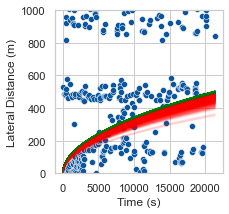

In [112]:
# posterior predictive check
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(3,3))
t = np.linspace(1,stg_dist.t_start_s.max(),1000)
sns.scatterplot(x=stg_dist.t_start_s,y=stg_dist.dx_strike_m.abs(), ax=ax)
for chain in nonlinear_trace.posterior.chain.values:
    draws = np.random.choice(linear_trace.posterior.sel({'chain':chain}).draw.values, 100)
    for draw in draws:
        k = nonlinear_trace.posterior.sel({'chain':chain, 'draw':draw}).k.values
        Po = nonlinear_trace.posterior.sel({'chain':chain, 'draw':draw}).Po.values
        Do = nonlinear_trace.posterior.sel({'chain':chain, 'draw':draw}).Do_x.values
        sns.lineplot(x=t, y=np.sqrt(6*Do*t), color='red', alpha=0.1)
        sns.lineplot(x=t, y=calc_tilda_c(k, Po)*np.sqrt(Do*t), color='green', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Lateral Distance (m)')
plt.ylim(0,1000)

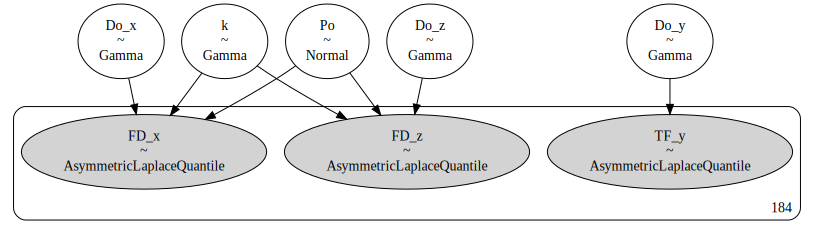

In [61]:
gv = pm.model_to_graphviz(nonlinear_model)
gv.render(filename='model',format='pdf')
gv

# Compare Diffusivities

In [79]:
# post-process bayesian diffusivity results
bayes_diff_list = pd.concat([
    pd.read_parquet(x) for x in 
    Path('outputs/').glob(f"{well}_{stage}*.parquet")
    ]).reset_index().rename(columns={'index':'variable'})
bayes_diffusivity = (bayes_diff_list
    .query("variable in ('Do_x','Do_y','Do_z')")
    .pivot(index=['uwi','stage','model'], columns=['variable'], values=['mean','sd','hdi_3%','hdi_97%'])
    )
bayes_diffusivity.columns = bayes_diffusivity.columns.map('_'.join).str.strip('_')
bayes_diffusivity = (bayes_diffusivity
    .reset_index()
    .rename(columns={'uwi':"WellID", 'stage':"Stage"})
    .assign(WellID = lambda x: x.WellID.astype(int))
    )

In [107]:
# filter based on non-linear diffusivity
# calculate maximum likelihood diffusivity
freq_diffusivity = (
    stg_dist
    .query("in_frac_ellipsoid") # the filter column
    .reset_index(drop=True)
    .groupby(["WellID", "Stage"])
    .apply(calculate_lsq_diffusivities, quantile=0.95)
    .assign(model = 'maximum_likelihood')
    .reset_index(drop=True)
)

combined_diff_results = pd.concat([bayes_diffusivity, freq_diffusivity], axis=0)

In [108]:
combined_diff_results

,WellID,Stage,model,mean_Do_x,mean_Do_y,mean_Do_z,sd_Do_x,sd_Do_y,sd_Do_z,hdi_3%_Do_x,hdi_3%_Do_y,hdi_3%_Do_z,hdi_97%_Do_x,hdi_97%_Do_y,hdi_97%_Do_z,n_events,loss_Do_x,loss_Do_y,loss_Do_z
0,4.0,7.0,linear,8.885000,0.90500,2.050000,0.071,0.029,0.042,8.771,0.863,1.961,9.021,0.958,2.122,NaN,NaN,NaN,NaN
1,4.0,7.0,nonlinear,1.632000,0.90500,0.152000,0.174,0.029,0.017,1.314,0.862,0.118,1.903,0.959,0.178,NaN,NaN,NaN,NaN
0,4.0,7.0,maximum_likelihood,2.835238,0.87777,2.072837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.0,26.173189,10.74012,12.641659
